In [5]:
%reset -f
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


import seaborn as snsRadius
import os
from scipy.spatial import distance

from fractions import Fraction
from itertools import product

import latexify

In [6]:
def make_title(file_name: str) -> str:
    # Split the string by underscores
    parts = file_name.split('_')
    # Initialize an empty list to store extracted information
    extracted_info = []
    # Initialize variables to store sensor range and sensing range
    sensor_range = None
    sensing_range = None
    # Iterate over parts to extract relevant information
    for part in parts:
        # Extract information for desired keywords
        if 'Agents' in part:
            extracted_info.append(part.replace('Agents[', 'Agents: ').replace(']', ''))
        elif 'Preys' in part:
            extracted_info.append(part.replace('Preys[', 'Preys: ').replace(']', ''))
        elif 'steps' in part:
            extracted_info.append(part.replace('steps[', 'Steps: ').replace(']', ''))
        elif 'kappa' in part:
            extracted_info.append(part.replace('kappa[', 'Kappa: ').replace(']', ''))
        elif 'precentageNoSensor' in part:
            extracted_info.append(part.replace('precentageNoSensor[', 'Percentage No Sensor: ').replace(']', ''))
        elif 'minDistance' in part:
            extracted_info.append(part.replace('minDistance[', 'Min Distance: ').replace(']', ''))
        elif 'sensingRange' in part:
            sensing_range = int(part.split('[')[1].split(']')[0])
            extracted_info.append(part.replace('sensingRange[', 'Sensing Range: ').replace(']', ''))
        elif 'sensorRange' in part:
            sensor_range = int(part.split('[')[1].split(']')[0])
            extracted_info.append(part.replace('sensorRange[', 'Sensor Range: ').replace(']', ''))
        elif 'pdm' in part:
            extracted_info.append(part.replace('pdm[', 'Pdm: ').replace(']', ''))
        elif 'DpPdm' in part:
            extracted_info.append(part.replace('DpPdm[', 'DpPdm: ').replace(']', ''))
        elif 'exp' in part:
            extracted_info.append(part.replace('exp[', 'Exp: ').replace('].csv', ''))
    # Include sensor/sensing range ratio in the title
    ratios = [Fraction(sensor_range, sensing_range).limit_denominator() for sensing_range, sensor_range in product([sensing_range], [sensor_range])]
    ratios_str = [f"{r.numerator}:{r.denominator}" for r in ratios]
    extracted_info.append(f'Sensor/Sensing Range Ratio: {ratios_str[0]}')
    # Join the extracted information to form the title
    title = ', '.join(extracted_info)
    return title



def compute_distances(data):
    prey = data[data['isPredator'] == 0]
    predator = data[data['isPredator'] == 1]
    
    # Compute distances among predator neighbors
    predator_positions = predator.groupby('step')[['x', 'y']].apply(lambda x: x.values.tolist())
    predator_distances = predator_positions.apply(lambda x: np.mean(distance.pdist(x)))
    
    # Compute distances between prey and predator
    swarm_pred_center_per_step = predator.groupby('step')[['x', 'y']].mean()
    swarm_prey_center_per_step = prey.groupby('step')[['x', 'y']].mean()
    prey_predator_distances = np.sqrt((swarm_prey_center_per_step['x'] - swarm_pred_center_per_step['x'])**2 + 
                                     (swarm_prey_center_per_step['y'] - swarm_pred_center_per_step['y'])**2)
                                     
    
    # Compute order of the predators
    predator_order = predator.groupby('step')['theta'].apply(compute_order_parameter2)
    
    return predator_distances, prey_predator_distances, predator_order

def compute_order_parameter2(group: pd.DataFrame) -> float:
    """
    Compute the order parameter for the given group
    """
    N = len(group)  # use the length of the group
    sum_exp = np.sum(np.exp(1j * group))  # sum of complex exponentials of the angles
    order_parameter = np.abs(sum_exp) / N  # order parameter
    return order_parameter

# @latexify.function
def compute_order_parameter(group: pd.DataFrame) -> pd.Series:
    """
    Compute the order parameter for the given group
    """
    
    # print(group)
    N = len(group)  # use the length of the group
    sum_exp = np.sum(np.exp(1j * group))  # sum of complex exponentials of the angles
    order_parameter = np.abs(sum_exp) / N  # order parameter
    return pd.Series([order_parameter] * len(group), index=group.index)


compute_order_parameter

def plot_data(data: pd.DataFrame):
    title = make_title(data['exp_name'].iloc[0])
    # print(title)

    prey     = data[data['isPredator'] == 0]
    predator = data[data['isPredator'] == 1]

    steps = data['step'].astype(int).unique()

    trajectory_prey     = prey.groupby('step')[['x', 'y']].mean()
    trajectory_predator = predator.groupby('step')[['x', 'y']].mean()


    last_steps_positions_predators = predator[predator['step'] == predator['step'].max()]
    last_steps_positions_prey      = prey[prey['step'] == prey['step'].max()]


    prey['order_parameter']     = prey.groupby('step')['theta'].transform(compute_order_parameter)
    predator['order_parameter'] = predator.groupby('step')['theta'].transform(compute_order_parameter)


    swarm_pred_center_per_step = predator.groupby('step')[['x', 'y']].mean()
    swarm_prey_center_per_step = prey.groupby('step')[['x', 'y']].mean()

    distance = np.sqrt((swarm_prey_center_per_step['x'] - swarm_pred_center_per_step['x'])**2 + (swarm_prey_center_per_step['y'] - swarm_pred_center_per_step['y'])**2)

    # velocity use vx and vy
    predator['speed'] = np.sqrt(predator['vx']**2 + predator['vy']**2)
    prey['speed'] = np.sqrt(prey['vx']**2 + prey['vy']**2)


    mean_speed_pred_per_step = predator.groupby('step')['speed'].mean()
    mean_speed_prey_per_step = prey.groupby('step')['speed'].mean()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    plt.suptitle(title)

    # plot trajectory
    axs[0].plot(trajectory_prey['x'], trajectory_prey['y'], label='Prey')
    axs[0].plot(trajectory_predator['x'], trajectory_predator['y'], label='Predator')

    axs[0].scatter(last_steps_positions_prey['x'], last_steps_positions_prey['y'], label='Prey', color='blue')
    # change color of the predator if no sensor
    predators_with_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 1]
    predators_without_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 0]
    axs[0].scatter(predators_with_sensor['x'], predators_with_sensor['y'], label='Predator', color='red')
    axs[0].scatter(predators_without_sensor['x'], predators_without_sensor['y'], label='Predator no sensor', color='green')

    axs[0].quiver(last_steps_positions_prey['x'], last_steps_positions_prey['y'], np.cos(last_steps_positions_prey['theta']), np.sin(last_steps_positions_prey['theta']), color='blue')
    # axs[0].quiver(last_steps_positions_predators['x'], last_steps_positions_predators['y'], np.cos(last_steps_positions_predators['theta']), np.sin(last_steps_positions_predators['theta']), color='red')
    axs[0].quiver(predators_with_sensor['x'], predators_with_sensor['y'], np.cos(predators_with_sensor['theta']), np.sin(predators_with_sensor['theta']), color='red')
    axs[0].quiver(predators_without_sensor['x'], predators_without_sensor['y'], np.cos(predators_without_sensor['theta']), np.sin(predators_without_sensor['theta']), color='green')

    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_title('Trajectory')
    axs[0].legend()

    # plot order parameter
    axs[1].plot(prey['step'], prey['order_parameter'], label='Prey')
    axs[1].plot(predator['step'], predator['order_parameter'], label='Predator')
    axs[1].set_xlabel('step')
    axs[1].set_ylabel('order_parameter')
    axs[1].set_title('Order Parameter')
    axs[1].legend()


    # plot average distance between the two swarms
    axs[2].plot(steps, distance)
    axs[2].set_xlabel('step')
    axs[2].set_ylabel('distance')
    axs[2].set_title('Distance between the two swarms')

    # plot average distance between the two swarms
    axs[3].plot(steps, mean_speed_pred_per_step, label='Predator')
    axs[3].plot(steps, mean_speed_prey_per_step, label='Prey')
    axs[3].set_xlabel('step')
    axs[3].set_ylabel('speed')
    axs[3].set_title('Mean Speed')
    axs[3].legend()

In [3]:
from fractions import Fraction
# Experiment IDs
# experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
num_exps = 5
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
# Parameters
folders = ['ratios_2']
N_preys = [30]
N_agent = [30]
sensing_range = [1, 2, 3, 4]  # Prey
sensor_range = [1, 2, 3, 4]  # Predator
percentage_no_sensor = [0.0, 0.75, 0.99]
total_steps_per_simulation = 10000

specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# Define allowed ratios for min_distance calculation
allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        # print(f'Ratio: {ratio}')  # Debug statement
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))


# print(f'Valid combinations: {valid_combinations}')  # Debug statement

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].csv')
                        # Agents[30]_Preys[30]_steps[10000]_kappa[1.0]_precentageNoSensor[0.75]_minDistance[5.0]_sensingRange[5]_sensorRange[5]_pdm[True]_DpPdm[3.0]_exp[1].csv
                        # Agents[30]_Preys[30]_steps[10000]_kappa[3.0]_precentageNoSensor[0.99]_minDistance[6.0]_sensingRange[6]_sensorRange[6]_pdm[True]_DpPdm[3.0]_exp[1].csv

In [4]:
dfs = []
for file in file_names:
    for folder in folders:
        try:
            df = pd.read_csv(f'dataPreyPredator/{folder}/{file}')
            df['exp_name'] = file
            dfs.append(df)
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

In [36]:
# len(dfs)

In [42]:
# for df in dfs:
#     plot_data(df)
#     plt.show()

# dfs[0]['exp_name'].iloc[0]

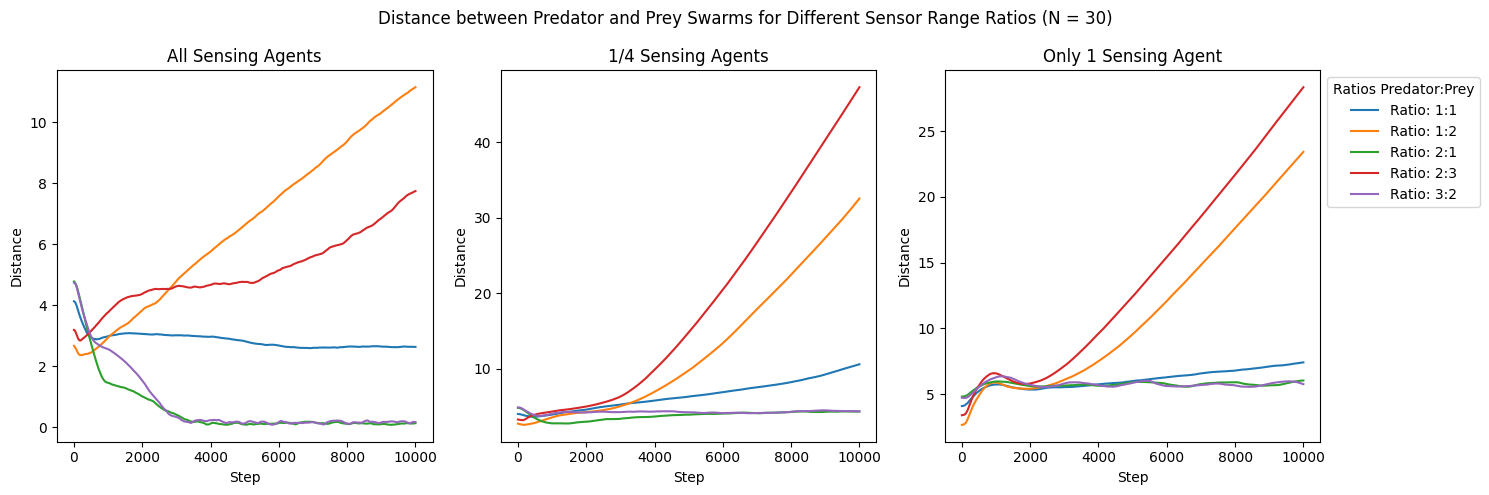

In [5]:
dfs_min_distances = {}

for df in dfs:
    exp_id = df['exp_name'].iloc[0].split('exp[')[1].split('].csv')[0]
    percentage_no_sensor = df['exp_name'].iloc[0].split('precentageNoSensor[')[1].split(']')[0]
    sensor_range = df['exp_name'].iloc[0].split('sensorRange[')[1].split(']')[0]
    sensing_range = df['exp_name'].iloc[0].split('sensingRange[')[1].split(']')[0]
    ratio = Fraction(int(sensor_range), int(sensing_range)).limit_denominator()
    ratio = f'{ratio.numerator}:{ratio.denominator}'
    if (exp_id, ratio, percentage_no_sensor) not in dfs_min_distances:
        dfs_min_distances[(exp_id, ratio, percentage_no_sensor)] = []
    dfs_min_distances[(exp_id, ratio, percentage_no_sensor)].append(df)

dfs_min_distances.keys()

# Step 1: Aggregate the data across all experiment IDs for each condition
prey_predator_distances_per_ratio = {}
for key, dfs_array in dfs_min_distances.items():
    exp_id = key[0]
    ratio = key[1]
    percentage_no_sensor = key[2]

    for df in dfs_array:
        predator_distances, prey_predator_distances, predator_order = compute_distances(df)
        if (ratio, percentage_no_sensor) not in prey_predator_distances_per_ratio:
            prey_predator_distances_per_ratio[(ratio, percentage_no_sensor)] = []

        prey_predator_distances_per_ratio[(ratio, percentage_no_sensor)].append(prey_predator_distances)

# Step 2: Calculate the average distance per step for each condition
avg_distance_per_step = {}
for key, prey_predator_distances_list in prey_predator_distances_per_ratio.items():
    avg_distances = pd.DataFrame(prey_predator_distances_list).mean().tolist()
    avg_distance_per_step[key] = avg_distances

# Step 3: Plot the averages per step with legends representing kappa with percentage no sensor
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for min_distance, avg_distance in avg_distance_per_step.items():
    ratio = min_distance[0]
    percentage_no_sensor = min_distance[1]
    if percentage_no_sensor == '0.0':
        ax[0].plot(range(len(avg_distance)), avg_distance, label=f'Ratio: {ratio}')
        ax[0].set_xlabel('Step')
        ax[0].set_ylabel('Distance')
        ax[0].set_title('All Sensing Agents')
    elif percentage_no_sensor == '0.75':
        ax[1].plot(range(len(avg_distance)), avg_distance, label=f'Ratio: {ratio}')
        ax[1].set_xlabel('Step')
        ax[1].set_ylabel('Distance')
        ax[1].set_title('1/4 Sensing Agents')
    elif percentage_no_sensor == '0.99':
        ax[2].plot(range(len(avg_distance)), avg_distance, label=f'Ratio: {ratio}')
        ax[2].set_xlabel('Step')
        ax[2].set_ylabel('Distance')
        ax[2].set_title('Only 1 Sensing Agent')

# Adjust the legend and titles
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Ratios Predator:Prey')
plt.suptitle('Distance between Predator and Prey Swarms for Different Sensor Range Ratios (N = 30)')
plt.tight_layout()
plt.show()

In [7]:
from fractions import Fraction
# Experiment IDs
# experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
num_exps = 5
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
# Parameters
folders = ['sensors3']
N_preys = [100]
N_agent = [100]
sensing_range = [1, 2, 3, 4]  # Prey
sensor_range = [1, 2, 3, 4]  # Predator
percentage_no_sensor = [0.0, 0.75, 0.99]
total_steps_per_simulation = 10000

specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# Define allowed ratios for min_distance calculation
allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        # print(f'Ratio: {ratio}')  # Debug statement
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))


# print(f'Valid combinations: {valid_combinations}')  # Debug statement

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].csv')
                        # Agents[30]_Preys[30]_steps[10000]_kappa[1.0]_precentageNoSensor[0.75]_minDistance[5.0]_sensingRange[5]_sensorRange[5]_pdm[True]_DpPdm[3.0]_exp[1].csv
                        # Agents[30]_Preys[30]_steps[10000]_kappa[3.0]_precentageNoSensor[0.99]_minDistance[6.0]_sensingRange[6]_sensorRange[6]_pdm[True]_DpPdm[3.0]_exp[1].csv

dfs = []
for file in file_names:
    for folder in folders:
        try:
            df = pd.read_csv(f'dataPreyPredator/{folder}/{file}')
            df['exp_name'] = file
            dfs.append(df)
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

dfs_min_distances = {}

for df in dfs:
    exp_id = df['exp_name'].iloc[0].split('exp[')[1].split('].csv')[0]
    percentage_no_sensor = df['exp_name'].iloc[0].split('precentageNoSensor[')[1].split(']')[0]
    sensor_range = df['exp_name'].iloc[0].split('sensorRange[')[1].split(']')[0]
    sensing_range = df['exp_name'].iloc[0].split('sensingRange[')[1].split(']')[0]
    ratio = Fraction(int(sensor_range), int(sensing_range)).limit_denominator()
    ratio = f'{ratio.numerator}:{ratio.denominator}'
    if (exp_id, ratio, percentage_no_sensor) not in dfs_min_distances:
        dfs_min_distances[(exp_id, ratio, percentage_no_sensor)] = []
    dfs_min_distances[(exp_id, ratio, percentage_no_sensor)].append(df)

dfs_min_distances.keys()

# Step 1: Aggregate the data across all experiment IDs for each condition
prey_predator_distances_per_ratio = {}
for key, dfs_array in dfs_min_distances.items():
    exp_id = key[0]
    ratio = key[1]
    percentage_no_sensor = key[2]

    for df in dfs_array:
        predator_distances, prey_predator_distances, predator_order = compute_distances(df)
        if (ratio, percentage_no_sensor) not in prey_predator_distances_per_ratio:
            prey_predator_distances_per_ratio[(ratio, percentage_no_sensor)] = []

        prey_predator_distances_per_ratio[(ratio, percentage_no_sensor)].append(prey_predator_distances)

# Step 2: Calculate the average distance per step for each condition
avg_distance_per_step = {}
for key, prey_predator_distances_list in prey_predator_distances_per_ratio.items():
    avg_distances = pd.DataFrame(prey_predator_distances_list).mean().tolist()
    avg_distance_per_step[key] = avg_distances

# Step 3: Plot the averages per step with legends representing kappa with percentage no sensor
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for min_distance, avg_distance in avg_distance_per_step.items():
    ratio = min_distance[0]
    percentage_no_sensor = min_distance[1]
    if percentage_no_sensor == '0.0':
        ax[0].plot(range(len(avg_distance)), avg_distance, label=f'Ratio: {ratio}')
        ax[0].set_xlabel('Step')
        ax[0].set_ylabel('Distance')
        ax[0].set_title('All Sensing Agents')
    elif percentage_no_sensor == '0.75':
        ax[1].plot(range(len(avg_distance)), avg_distance, label=f'Ratio: {ratio}')
        ax[1].set_xlabel('Step')
        ax[1].set_ylabel('Distance')
        ax[1].set_title('1/4 Sensing Agents')
    elif percentage_no_sensor == '0.99':
        ax[2].plot(range(len(avg_distance)), avg_distance, label=f'Ratio: {ratio}')
        ax[2].set_xlabel('Step')
        ax[2].set_ylabel('Distance')
        ax[2].set_title('Only 1 Sensing Agent')

# Adjust the legend and titles
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Ratios Predator:Prey')
plt.suptitle('Distance between Predator and Prey Swarms for Different Sensor Range Ratios (N = 30)')
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
num_exps = 30
folders = ['last_steps']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [30]
N_agent = [30]
sensing_range = [3]  # Prey
sensor_range =  [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 100)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 30000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# 

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)
# print(f'Allowed ratios: {allowed_ratios}')  

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        # print(f'Ratio: {ratio}')  # Debug statement
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))


file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].csv')
                # Agents[30]_Preys[30]_steps[10000]_precentageNoSensor[0.58]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[1].csv 
                # Agents[30]_Preys[30]_steps[10000]_precentageNoSensor[0.58]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[1].csv



dfs = []
for file in file_names:
    for folder in folders:
        try:
            df = pd.read_csv(f'dataPreyPredator/{folder}/{file}')
            df['exp_name'] = file
            dfs.append(df)
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

# for df in dfs:

#     plot_data(df)
#     plt.show()


experiments = {}

for df in dfs:
    percentage_no_sensor = df['exp_name'].iloc[0].split('precentageNoSensor[')[1].split(']')[0]
    exp_id = df['exp_name'].iloc[0].split('exp[')[1].split('].csv')[0]
    # take the distance between the two swarms at the last step
    predator_distances, prey_predator_distances, predator_order = compute_distances(df)
    # take last step
    last_step = df['step'].max()
    prey_predator_distances_last_step = prey_predator_distances[last_step]
    
    # take averages of last step per experiment
    if (exp_id, percentage_no_sensor) not in experiments:
        experiments[(exp_id, percentage_no_sensor)] = []
    experiments[(exp_id, percentage_no_sensor)].append(prey_predator_distances_last_step)

# Step 1: Aggregate the data across all experiment IDs for each condition
avg_distance_per_percentage = {}

for key, distances in experiments.items():
    exp_id = key[0]
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in avg_distance_per_percentage:
        avg_distance_per_percentage[percentage_no_sensor] = []
    avg_distance_per_percentage[percentage_no_sensor].extend(distances)

# Calculate the average distance for each percentage
for percentage_no_sensor in avg_distance_per_percentage:
    avg_distance_per_percentage[percentage_no_sensor] = np.mean(avg_distance_per_percentage[percentage_no_sensor])

# Step 2: Plot the averages
# Reverse the data for plotting
percentages = sorted(map(float, avg_distance_per_percentage.keys()), reverse=False)
average_distances = [avg_distance_per_percentage[str(p)] for p in percentages]

plt.figure(figsize=(10, 6))
plt.plot(percentages, average_distances, marker='o')
plt.xlabel('Sensing Agents (%)')
plt.ylabel('Distance between Swarms center of mass')
plt.title('Distances Between Swarms at the last step vs. Percentage No Sensor over 30 Experiments')
plt.show()


[0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8, 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.0]


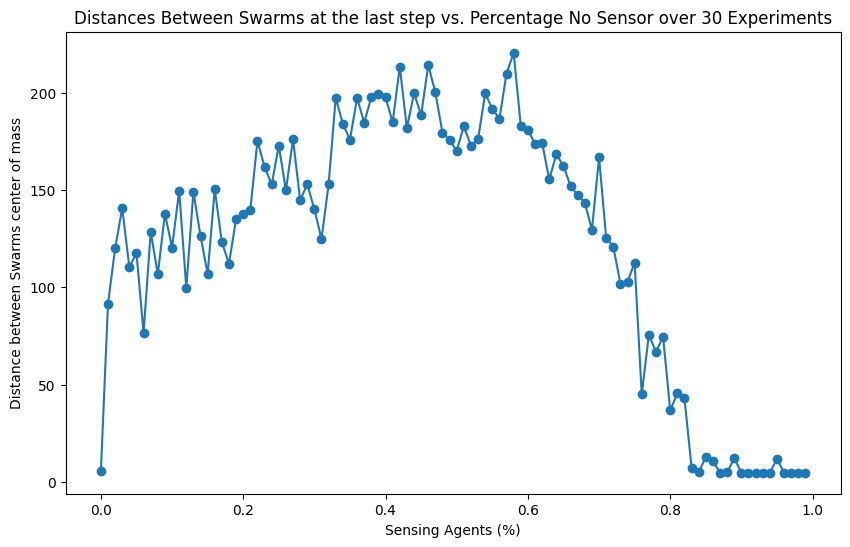

In [13]:
percentages = sorted(map(float, avg_distance_per_percentage.keys()), reverse=True)
print(percentages)
average_distances = [avg_distance_per_percentage[str(p)] for p in percentages]
# reverse the order of average_distances
average_distances = average_distances[::-1]

plt.figure(figsize=(10, 6))
plt.plot(percentages, average_distances, marker='o')
plt.xlabel('Sensing Agents (%)')
plt.ylabel('Distance between Swarms center of mass')
plt.title('Distances Between Swarms at the last step vs. Percentage No Sensor over 30 Experiments')
plt.show()

# other stuff


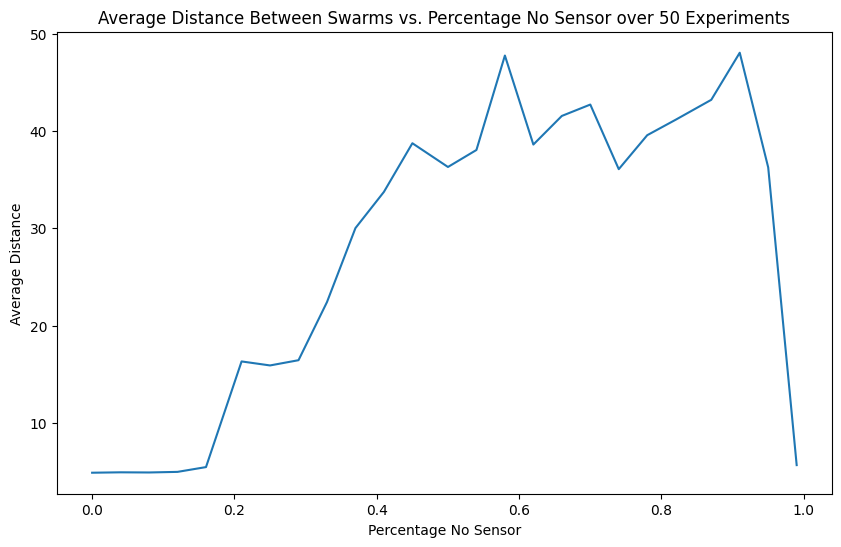

In [7]:
import numpy as np
import pandas as pd
from fractions import Fraction
from itertools import product
import matplotlib.pyplot as plt

# Parameters
num_exps = 50
folders = ['last_steps2']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [30]
N_agent = [30]
sensing_range = [3]  # Prey
sensor_range = [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 25)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 10000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)

valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))

file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[True]_exp[{exp_id}].csv')

dfs = []
for file in file_names:
    for folder in folders:
        try:
            df = pd.read_csv(f'dataPreyPredator/{folder}/{file}')
            df['exp_name'] = file
            dfs.append(df)
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')

experiments = {}

for df in dfs:
    percentage_no_sensor = df['exp_name'].iloc[0].split('precentageNoSensor[')[1].split(']')[0]
    exp_id = df['exp_name'].iloc[0].split('exp[')[1].split('].csv')[0]
    # Take the distance between the two swarms at the last step
    predator_distances, prey_predator_distances, predator_order = compute_distances(df)
    # Take last step
    last_step = df['step'].max()
    prey_predator_distances_last_step = prey_predator_distances[last_step]
    
    # Take averages of last step per experiment
    if (exp_id, percentage_no_sensor) not in experiments:
        experiments[(exp_id, percentage_no_sensor)] = []
    experiments[(exp_id, percentage_no_sensor)].append(prey_predator_distances_last_step)

# Step 1: Aggregate the data across all experiment IDs for each condition
avg_distance_per_percentage = {}
std_distance_per_percentage = {}

for key, distances in experiments.items():
    exp_id = key[0]
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in avg_distance_per_percentage:
        avg_distance_per_percentage[percentage_no_sensor] = []
    avg_distance_per_percentage[percentage_no_sensor].extend(distances)

# Calculate the average distance and standard deviation for each percentage
for percentage_no_sensor in avg_distance_per_percentage:
    avg_distance_per_percentage[percentage_no_sensor] = np.mean(avg_distance_per_percentage[percentage_no_sensor])
    std_distance_per_percentage[percentage_no_sensor] = np.std(avg_distance_per_percentage[percentage_no_sensor])

# Step 2: Plot the averages with standard deviation
percentages = sorted(map(float, avg_distance_per_percentage.keys()))
average_distances = [avg_distance_per_percentage[str(p)] for p in percentages]
std_distances = [std_distance_per_percentage[str(p)] for p in percentages]

plt.figure(figsize=(10, 6))
plt.errorbar(percentages, average_distances, yerr=std_distances)
plt.xlabel('Percentage No Sensor')
plt.ylabel('Average Distance')
plt.title('Average Distance Between Swarms vs. Percentage No Sensor over 50 Experiments')
plt.show()


# normal p vector


In [19]:
# Parameters
num_exps = 50
folders = ['last_steps_normalP']
experiment_id_ = [str(i) for i in range(1, num_exps + 1)]
N_preys = [30]
N_agent = [30]
sensing_range = [3]  # Prey
sensor_range =  [3]  # Predator
percentage_no_sensor = np.linspace(0, 0.99, 25)
percentage_no_sensor = np.round(percentage_no_sensor, 2)
total_steps_per_simulation = 10000
specific_ratios = [Fraction(1, 1), Fraction(2, 1), Fraction(3, 2), Fraction(1, 2), Fraction(2, 3)]

# 

allowed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_reversed_ratios = set([Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensor_range, sensing_range) if Fraction(sensor, sensing).limit_denominator() in specific_ratios])
allowed_ratios = allowed_ratios.union(allowed_reversed_ratios)
# print(f'Allowed ratios: {allowed_ratios}')  

# Calculate combinations that match the allowed ratios
valid_combinations = []
for sr in sensor_range:
    for sensing_r in sensing_range:
        ratio = Fraction(sr, sensing_r)
        # print(f'Ratio: {ratio}')  # Debug statement
        reversed_ratio = (sensing_r, sr)
        if ratio in allowed_ratios or reversed_ratio in allowed_ratios:
            valid_combinations.append((sr, sensing_r))


file_names = []
for exp_id in experiment_id_:
    for N_prey in N_preys:
        for percentage in percentage_no_sensor:
            for N_agent_ in N_agent:
                for (sensor_range_, sensing_range_) in valid_combinations:
                    file_names.append(f'Agents[{N_agent_}]_Preys[{N_prey}]_steps[{total_steps_per_simulation}]_precentageNoSensor[{percentage}]_sensingRange[{sensing_range_}]_sensorRange[{sensor_range_}]_pdm[False]_exp[{exp_id}].csv')
                # Agents[30]_Preys[30]_steps[10000]_precentageNoSensor[0.58]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[1].csv 
                # Agents[30]_Preys[30]_steps[10000]_precentageNoSensor[0.58]_sensingRange[3]_sensorRange[3]_pdm[True]_exp[1].csv


In [20]:
dfs = []
for file in file_names:
    for folder in folders:
        try:
            df = pd.read_csv(f'dataPreyPredator/{folder}/{file}')
            df['exp_name'] = file
            dfs.append(df)
        except FileNotFoundError:
            print(f'File {file} not found in folder {folder}')


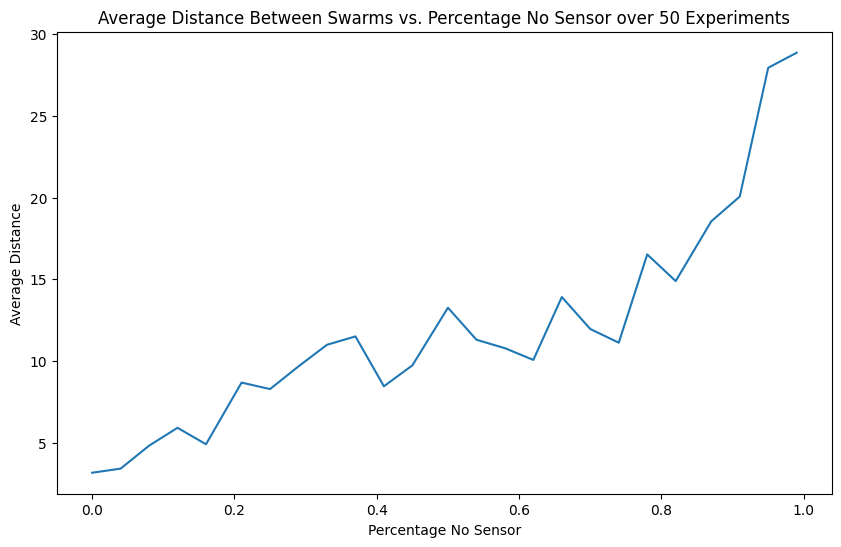

In [22]:

experiments = {}

for df in dfs:
    percentage_no_sensor = df['exp_name'].iloc[0].split('precentageNoSensor[')[1].split(']')[0]
    exp_id = df['exp_name'].iloc[0].split('exp[')[1].split('].csv')[0]
    # take the distance between the two swarms at the last step
    predator_distances, prey_predator_distances, predator_order = compute_distances(df)
    # take last step
    last_step = df['step'].max()
    prey_predator_distances_last_step = prey_predator_distances[last_step]
    
    # take averages of last step per experiment
    if (exp_id, percentage_no_sensor) not in experiments:
        experiments[(exp_id, percentage_no_sensor)] = []
    experiments[(exp_id, percentage_no_sensor)].append(prey_predator_distances_last_step)

# Step 1: Aggregate the data across all experiment IDs for each condition
avg_distance_per_percentage = {}

for key, distances in experiments.items():
    exp_id = key[0]
    percentage_no_sensor = key[1]
    if percentage_no_sensor not in avg_distance_per_percentage:
        avg_distance_per_percentage[percentage_no_sensor] = []
    avg_distance_per_percentage[percentage_no_sensor].extend(distances)

# Calculate the average distance for each percentage
for percentage_no_sensor in avg_distance_per_percentage:
    avg_distance_per_percentage[percentage_no_sensor] = np.mean(avg_distance_per_percentage[percentage_no_sensor])

# Step 2: Plot the averages
percentages = sorted(map(float, avg_distance_per_percentage.keys()))
average_distances = [avg_distance_per_percentage[str(p)] for p in percentages]

plt.figure(figsize=(10, 6))
plt.plot(percentages, average_distances)
plt.xlabel('Percentage No Sensor')
plt.ylabel('Average Distance')
plt.title('Average Distance Between Swarms vs. Percentage No Sensor over 50 Experiments')
plt.show()